In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
from google.colab import drive

# # Load dataset

# data_path = "/content/drive/MyDrive/minor/carla_data_all_upto23/rollout_6.npz"
# data = np.load(data_path, allow_pickle=True)  # allow_pickle is necessary for lists

import os
import glob
import numpy as np
drive.mount('/content/drive')

directories = [
    "/content/drive/MyDrive/minor/carla_data_all_upto23",
    "/content/drive/MyDrive/minor/carla_data_all_session2",
    "/content/drive/MyDrive/minor/carla_data_all"
]


Mounted at /content/drive


In [ ]:
states = []
action1 = []

for folder in directories:
    files = glob.glob(os.path.join(folder, "*.npz"))
    for file_path in files:
        data = np.load(file_path, allow_pickle=True)
        observations = data["observations"]
        actions = data["actions"]
        N = min(len(observations), len(actions))

        for i in range(N):
            comp_img = observations[i]
            if isinstance(comp_img, np.ndarray) and comp_img.ndim == 0:
                comp_img = comp_img.item()

            states.append(comp_img)
            action1.append(actions[i])

all_images_array = np.array(states, dtype=object)
all_actions_array1 = np.array(action1)

print("Total images collected:", all_images_array.shape[0])
print("Total actions collected:", all_actions_array1.shape[0])

Total images collected: 39071
Total actions collected: 39071


In [ ]:
num_actions = len(action1)
all_actions_array = np.zeros((num_actions, 3))
for i in range(num_actions):
    action_dict = all_actions_array1[i]
    all_actions_array[i, 0] = action_dict['throttle']
    all_actions_array[i, 1] = action_dict['steer']
    all_actions_array[i, 2] = action_dict['brake']

print(all_actions_array[5])





[0.85000002 0.00181345 0.        ]


In [ ]:
# img = Image.open(io.BytesIO(all_images_array[0]))
# img_array = np.array(img)
# img_array = img_array / 255.0
# img_tensor = torch.from_numpy(img_array).unsqueeze(0).float()
# print(img_tensor.shape)

NameError: name 'Image' is not defined

In [ ]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),    # -> [32, 150, 150]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # -> [64, 75, 75]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> [128, 38, 38]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # -> [256, 19, 19]
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # -> [512, 10, 10]
            nn.ReLU()
        )

        self.flatten_size = 41472

        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, self.flatten_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # -> [256, 19, 19]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> [128, 38, 38]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # -> [64, 75, 75]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # -> [32, 150, 150]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=16, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)     # sample from N(0,1)
        return mu + std * eps           # z = mu + sigma * epsilon

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 512, 9, 9)
        x = self.decoder(x)
        return x


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [ ]:
latent_dim = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim).to(device)
vae.load_state_dict(torch.load("/content/drive/MyDrive/vae_model_epoch_20.pth", map_location=device))
vae.eval()
print("VAE loaded.")

VAE loaded.


<ipython-input-17-37507e60b825>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("/content/drive/MyDrive/vae_model_epoch_20.pth", map_location

In [ ]:
class MDNRNN(nn.Module):
    def __init__(self, latent_dim=64, action_dim=3, hidden_dim=512, n_gaussians=5):
        super(MDNRNN, self).__init__()
        self.latent_dim = latent_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.n_gaussians = n_gaussians

        self.input_dim = latent_dim + action_dim
        self.lstm = nn.LSTM(self.input_dim, hidden_dim, batch_first=True)


        self.fc_pi = nn.Linear(hidden_dim, n_gaussians)
        self.fc_mu = nn.Linear(hidden_dim, n_gaussians * latent_dim)
        self.fc_sigma = nn.Linear(hidden_dim, n_gaussians * latent_dim)

    def forward(self, x, hidden=None):
        # x -> [batch_size, seq_len, input_dim]
        out, hidden = self.lstm(x, hidden)


        pi = self.fc_pi(out)
        pi = nn.functional.softmax(pi, dim=-1)

        mu = self.fc_mu(out)
        mu = mu.view(x.size(0), x.size(1), self.n_gaussians, self.latent_dim)
        sigma = self.fc_sigma(out)
        sigma = sigma.view(x.size(0), x.size(1), self.n_gaussians, self.latent_dim)
        sigma = torch.exp(sigma)

        return pi, mu, sigma,hidden


In [ ]:
def mdn_loss(pi, mu, sigma, target):
    target = target.unsqueeze(2)


    exponent = -0.5 * ((target - mu) / (sigma + 1e-8))**2
    exponent = exponent.sum(dim=-1)

    latent_dim = target.size(-1)
    log_coef = -torch.log(sigma + 1e-8).sum(dim=-1) - 0.5 * latent_dim * np.log(2 * np.pi)

    log_probs = log_coef + exponent

    weighted_log_probs = torch.log(pi + 1e-8) + log_probs

    max_log, _ = torch.max(weighted_log_probs, dim=-1, keepdim=True)
    log_sum = max_log.squeeze(-1) + torch.log(torch.sum(torch.exp(weighted_log_probs - max_log), dim=-1))

    loss = -log_sum.mean()

    return loss


In [ ]:
mse_loss = nn.MSELoss()
class MDNRNNDataset(Dataset):
    def __init__(self, encoded_images, actions, vae, seq_len=50):
        self.seq_len = seq_len
        self.sequences = []
        print("Processing data to create MDN-RNN sequences...")
        z_list = []
        batch_size = 64
        with torch.no_grad():
            for i in range(0, len(encoded_images), batch_size):
                batch_end = min(i + batch_size, len(encoded_images))
                batch_images = [encoded_images[j] for j in range(i, batch_end)]
                batch_tensors = []
                for img_bytes in batch_images:
                    img = Image.open(io.BytesIO(img_bytes)).convert('L')
                    img_array = np.array(img)
                    img_array = img_array / 255.0
                    img_tensor = torch.from_numpy(img_array).unsqueeze(0).float().to(device)

                    batch_tensors.append(img_tensor)
                batch_tensor = torch.stack(batch_tensors, dim=0)
                mu, _ = vae.encode(batch_tensor)
                z_list.extend(mu.cpu().numpy())

                if (i+1) % 1000 == 0:
                    print(f"Encoded {i+1}/{len(encoded_images)} images")

        print("All images encoded, creating sequences...")

        total_transitions = len(z_list) - 1

        for i in range(0, total_transitions - seq_len):
            inp_seq = []
            target_z_seq = []
            for t in range(seq_len):
                current_idx = i + t
                z_t = z_list[current_idx]
                action_t = actions[current_idx]
                z_t_plus_1 = z_list[current_idx + 1]

                inp_seq.append(np.concatenate([z_t, action_t], axis=0))

                target_z_seq.append(z_t_plus_1)


            self.sequences.append((
                np.array(inp_seq),
                np.array(target_z_seq),
            ))

            if (i+1) % 1000 == 0:
                print(f"Created {i+1}/{total_transitions - seq_len} sequences")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        inp, target_z = self.sequences[idx]
        return (
            torch.tensor(inp, dtype=torch.float32),
            torch.tensor(target_z, dtype=torch.float32),
        )


In [ ]:
import io
from PIL import Image

In [ ]:
mdn_rnn = MDNRNN().to(device)
optimizer = optim.Adam(mdn_rnn.parameters(), lr=1e-3)
print("MDN-RNN model initialized.")

print("Creating MDN-RNN dataset...")
dataset = MDNRNNDataset(
    encoded_images=all_images_array,
    actions=all_actions_array,
    vae=vae,
    seq_len=50
)

MDN-RNN model initialized.
Creating MDN-RNN dataset...
Processing data to create MDN-RNN sequences...
All images encoded, creating sequences...
Created 1000/39020 sequences
Created 2000/39020 sequences
Created 3000/39020 sequences
Created 4000/39020 sequences
Created 5000/39020 sequences
Created 6000/39020 sequences
Created 7000/39020 sequences
Created 8000/39020 sequences
Created 9000/39020 sequences
Created 10000/39020 sequences
Created 11000/39020 sequences
Created 12000/39020 sequences
Created 13000/39020 sequences
Created 14000/39020 sequences
Created 15000/39020 sequences
Created 16000/39020 sequences
Created 17000/39020 sequences
Created 18000/39020 sequences
Created 19000/39020 sequences
Created 20000/39020 sequences
Created 21000/39020 sequences
Created 22000/39020 sequences
Created 23000/39020 sequences
Created 24000/39020 sequences
Created 25000/39020 sequences
Created 26000/39020 sequences
Created 27000/39020 sequences
Created 28000/39020 sequences
Created 29000/39020 seque

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(f"MDN-RNN dataset prepared. Total sequences: {len(dataset)}")

epochs = 50
losses = []
mdn_rnn.train()

print("Starting MDN-RNN training...")
for epoch in range(1, epochs+1):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}")

    for inp, target_z in progress_bar:
        inp = inp.to(device)           # [batch, seq_len, latent_dim + action_dim]
        target_z = target_z.to(device) # [batch, seq_len, latent_dim]
        optimizer.zero_grad()
        pi, mu, sigma, _ = mdn_rnn(inp)
        loss = mdn_loss(pi, mu, sigma, target_z)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch}/{epochs}, Average Loss: {avg_loss:.4f}")

    if epoch % 5 == 0:
        torch.save(mdn_rnn.state_dict(), f"/content/drive/MyDrive/mdn_rnn_carla_epoch_{epoch}.pth")
        print(f"Model saved at epoch {epoch}")

torch.save(mdn_rnn.state_dict(), "/content/drive/MyDrive/mdn_rnn_carla_final.pth")
print("MDN-RNN model training completed and saved!")

np.save("/content/drive/MyDrive/mdn_rnn_training_losses.npy", np.array(losses))
print("Training losses saved for analysis")


MDN-RNN dataset prepared. Total sequences: 39020
Starting MDN-RNN training...


Epoch 1/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.30it/s, loss=-62.5]


Epoch 1/50, Average Loss: -31.0303


Epoch 2/50: 100%|██████████| 1220/1220 [00:13<00:00, 88.32it/s, loss=-67.3]


Epoch 2/50, Average Loss: -60.3835


Epoch 3/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.95it/s, loss=-70.2]


Epoch 3/50, Average Loss: -66.7970


Epoch 4/50: 100%|██████████| 1220/1220 [00:13<00:00, 88.30it/s, loss=-63.1]


Epoch 4/50, Average Loss: -71.2310


Epoch 5/50: 100%|██████████| 1220/1220 [00:13<00:00, 88.27it/s, loss=-81.1]


Epoch 5/50, Average Loss: -74.4895
Model saved at epoch 5


Epoch 6/50: 100%|██████████| 1220/1220 [00:13<00:00, 89.01it/s, loss=-79.1]


Epoch 6/50, Average Loss: -77.4729


Epoch 7/50: 100%|██████████| 1220/1220 [00:13<00:00, 88.24it/s, loss=-70.6]


Epoch 7/50, Average Loss: -80.1217


Epoch 8/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.41it/s, loss=-80.3]


Epoch 8/50, Average Loss: -82.4004


Epoch 9/50: 100%|██████████| 1220/1220 [00:13<00:00, 88.12it/s, loss=-84.9]


Epoch 9/50, Average Loss: -84.4993


Epoch 10/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.95it/s, loss=-86.6]


Epoch 10/50, Average Loss: -86.3451
Model saved at epoch 10


Epoch 11/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.68it/s, loss=-93.4]


Epoch 11/50, Average Loss: -88.1108


Epoch 12/50: 100%|██████████| 1220/1220 [00:13<00:00, 88.88it/s, loss=-101]


Epoch 12/50, Average Loss: -89.4288


Epoch 13/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.49it/s, loss=-101]


Epoch 13/50, Average Loss: -90.6780


Epoch 14/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.94it/s, loss=-104]


Epoch 14/50, Average Loss: -92.0253


Epoch 15/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.66it/s, loss=-87.8]


Epoch 15/50, Average Loss: -93.4664
Model saved at epoch 15


Epoch 16/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.66it/s, loss=-96.8]


Epoch 16/50, Average Loss: -94.4246


Epoch 17/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.08it/s, loss=-81.4]


Epoch 17/50, Average Loss: -95.3834


Epoch 18/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.84it/s, loss=-98.1]


Epoch 18/50, Average Loss: -96.3210


Epoch 19/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.91it/s, loss=-110]


Epoch 19/50, Average Loss: -96.9855


Epoch 20/50: 100%|██████████| 1220/1220 [00:14<00:00, 82.84it/s, loss=-100]


Epoch 20/50, Average Loss: -98.0172
Model saved at epoch 20


Epoch 21/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.63it/s, loss=-98.7]


Epoch 21/50, Average Loss: -98.6669


Epoch 22/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.99it/s, loss=-108]


Epoch 22/50, Average Loss: -99.4920


Epoch 23/50: 100%|██████████| 1220/1220 [00:14<00:00, 83.31it/s, loss=-97.9]


Epoch 23/50, Average Loss: -100.1818


Epoch 24/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.85it/s, loss=-109]


Epoch 24/50, Average Loss: -100.7524


Epoch 25/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.50it/s, loss=-106]


Epoch 25/50, Average Loss: -101.1473
Model saved at epoch 25


Epoch 26/50: 100%|██████████| 1220/1220 [00:14<00:00, 87.14it/s, loss=-111]


Epoch 26/50, Average Loss: -101.7238


Epoch 27/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.75it/s, loss=-99.3]


Epoch 27/50, Average Loss: -102.3385


Epoch 28/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.47it/s, loss=-98.3]


Epoch 28/50, Average Loss: -102.6657


Epoch 29/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.66it/s, loss=-97.6]


Epoch 29/50, Average Loss: -103.3412


Epoch 30/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.34it/s, loss=-111]


Epoch 30/50, Average Loss: -103.6410
Model saved at epoch 30


Epoch 31/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.60it/s, loss=-107]


Epoch 31/50, Average Loss: -103.9409


Epoch 32/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.29it/s, loss=-105]


Epoch 32/50, Average Loss: -104.6599


Epoch 33/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.22it/s, loss=-110]


Epoch 33/50, Average Loss: -104.9825


Epoch 34/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.68it/s, loss=-99.1]


Epoch 34/50, Average Loss: -105.4282


Epoch 35/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.19it/s, loss=-100]


Epoch 35/50, Average Loss: -105.5724
Model saved at epoch 35


Epoch 36/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.76it/s, loss=-117]


Epoch 36/50, Average Loss: -106.0149


Epoch 37/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.51it/s, loss=-91.7]


Epoch 37/50, Average Loss: -106.3508


Epoch 38/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.74it/s, loss=-105]


Epoch 38/50, Average Loss: -106.6222


Epoch 39/50: 100%|██████████| 1220/1220 [00:14<00:00, 84.85it/s, loss=-115]


Epoch 39/50, Average Loss: -107.0898


Epoch 40/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.73it/s, loss=-126]


Epoch 40/50, Average Loss: -107.3788
Model saved at epoch 40


Epoch 41/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.20it/s, loss=-105]


Epoch 41/50, Average Loss: -107.4847


Epoch 42/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.01it/s, loss=-98.1]


Epoch 42/50, Average Loss: -107.7644


Epoch 43/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.05it/s, loss=-111]


Epoch 43/50, Average Loss: -108.1559


Epoch 44/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.92it/s, loss=-104]


Epoch 44/50, Average Loss: -108.2024


Epoch 45/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.69it/s, loss=-112]


Epoch 45/50, Average Loss: -108.8161
Model saved at epoch 45


Epoch 46/50: 100%|██████████| 1220/1220 [00:14<00:00, 85.77it/s, loss=-95.1]


Epoch 46/50, Average Loss: -108.9436


Epoch 47/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.17it/s, loss=-114]


Epoch 47/50, Average Loss: -108.9914


Epoch 48/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.36it/s, loss=-113]


Epoch 48/50, Average Loss: -109.6498


Epoch 49/50: 100%|██████████| 1220/1220 [00:14<00:00, 86.46it/s, loss=-110]


Epoch 49/50, Average Loss: -109.6310


Epoch 50/50: 100%|██████████| 1220/1220 [00:13<00:00, 87.56it/s, loss=-122]


Epoch 50/50, Average Loss: -109.7382
Model saved at epoch 50
MDN-RNN model training completed and saved!
Training losses saved for analysis


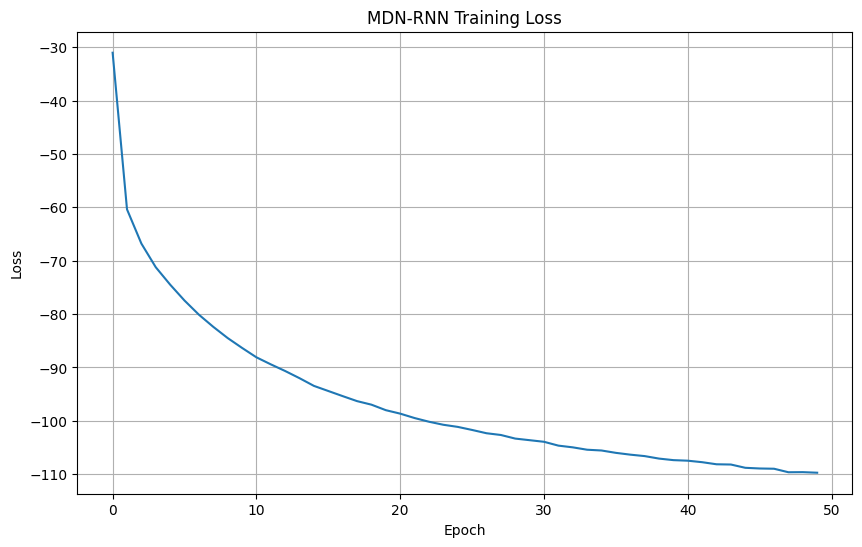

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('MDN-RNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig("/content/drive/MyDrive/mdn_rnn_training_curve.png")
plt.show()